In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import NASNetMobile
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import flask
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [2]:
sdir=r'D:\SKRIPSI\DATASET'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths       labels
0  D:\SKRIPSI\DATASET\daun kering\IMG_20240624_15...  daun kering
1  D:\SKRIPSI\DATASET\daun kering\IMG_20240624_15...  daun kering
2  D:\SKRIPSI\DATASET\daun kering\IMG_20240624_17...  daun kering
3  D:\SKRIPSI\DATASET\daun kering\IMG_20240624_17...  daun kering
4  D:\SKRIPSI\DATASET\daun kering\IMG_20240624_17...  daun kering
labels
daun kering    237
daun mozaik    236
daun sehat     235
Name: count, dtype: int64


In [3]:
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  637   test_df length:  35   valid_df length:  36


In [4]:
height=128
width=128
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(
    rescale=1./255
)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(
    rescale=1./255
)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  35   test steps:  1
Found 637 validated image filenames belonging to 3 classes.
Found 36 validated image filenames belonging to 3 classes.
Found 35 validated image filenames belonging to 3 classes.
['daun kering', 'daun mozaik', 'daun sehat']


In [5]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

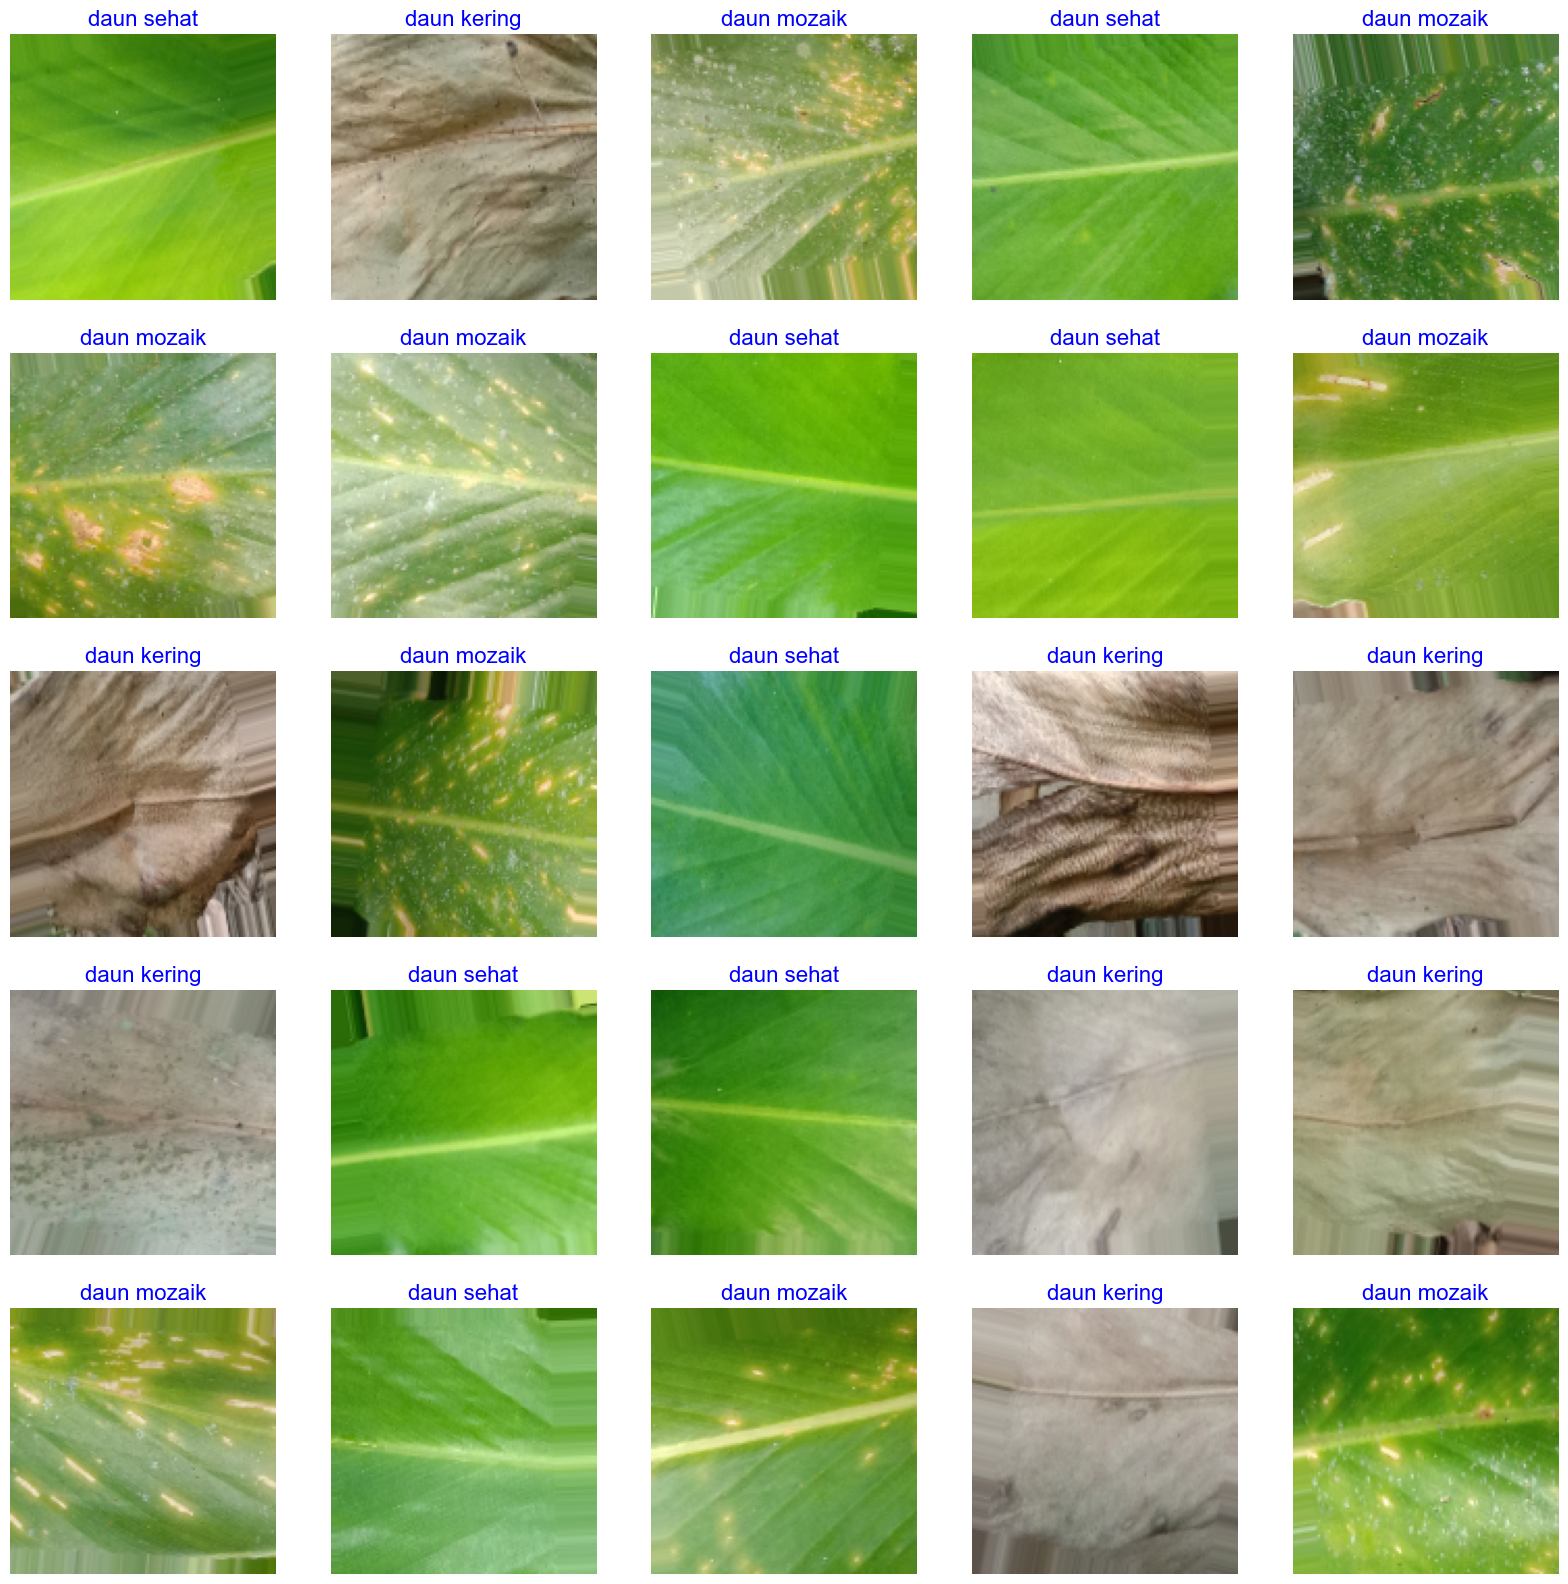

In [6]:
show_image_samples(train_gen)

In [7]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 63, 63, 32)   128         ['stem_conv1[0][0]']             
                                                                                                  
 activation (Activation)        (None, 63, 63, 32)   0           ['stem_bn1[0][0]']           

In [9]:
epochs=50
  
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen,callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 63s 4s/step - loss: 1.1004 - accuracy: 0.4427 - val_loss: 0.9394 - val_accuracy: 0.5556
Epoch 2/50
10/10 [==============================] - 28s 3s/step - loss: 0.8574 - accuracy: 0.6405 - val_loss: 0.7284 - val_accuracy: 0.8889
Epoch 3/50
10/10 [==============================] - 28s 3s/step - loss: 0.6250 - accuracy: 0.7834 - val_loss: 0.5963 - val_accuracy: 0.9167
Epoch 4/50
10/10 [==============================] - 28s 3s/step - loss: 0.5161 - accuracy: 0.8587 - val_loss: 0.5058 - val_accuracy: 0.9722
Epoch 5/50
10/10 [==============================] - 28s 3s/step - loss: 0.4464 - accuracy: 0.8964 - val_loss: 0.4393 - val_accuracy: 0.9722
Epoch 6/50
10/10 [==============================] - 28s 3s/step - loss: 0.3827 - accuracy: 0.9309 - val_loss: 0.3844 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 29s 3s/step - loss: 0.3510 - accuracy: 0.9341 - val_loss: 0.3400 - val_accuracy: 1.0000
Epoch 8/50
10/10 [==

In [10]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    # Mencetak teks dalam warna latar depan yang ditentukan oleh fore_tupple dan latar belakang yang ditentukan oleh back_tupple
    # txt_msg adalah teks, fore_tupple adalah tuple warna latar depan (r,g,b), back_tupple adalah tuple latar belakang (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)   # epoch dengan loss validasi terendah
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)     # epoch dengan akurasi validasi tertinggi
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')  #menggunakan gaya plot fivethirtyeight
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [16]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [12]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices   # mendapatkan index kelas dari generator pengujian
    labels= test_gen.labels             # mendapatkan label asli dari generator pengujian
    file_names= test_gen.filenames      # mendapatkan nama file gambar dari generator pengujian
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # membuat dictionary {integer of class number: string of class name}
    # simpan new_dict sbg file text di save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # mendapatkan indeks sebenarnya
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list jumlah kesalahan utk setiap kelas
                plot_class.append(value)   # simpan kelass 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

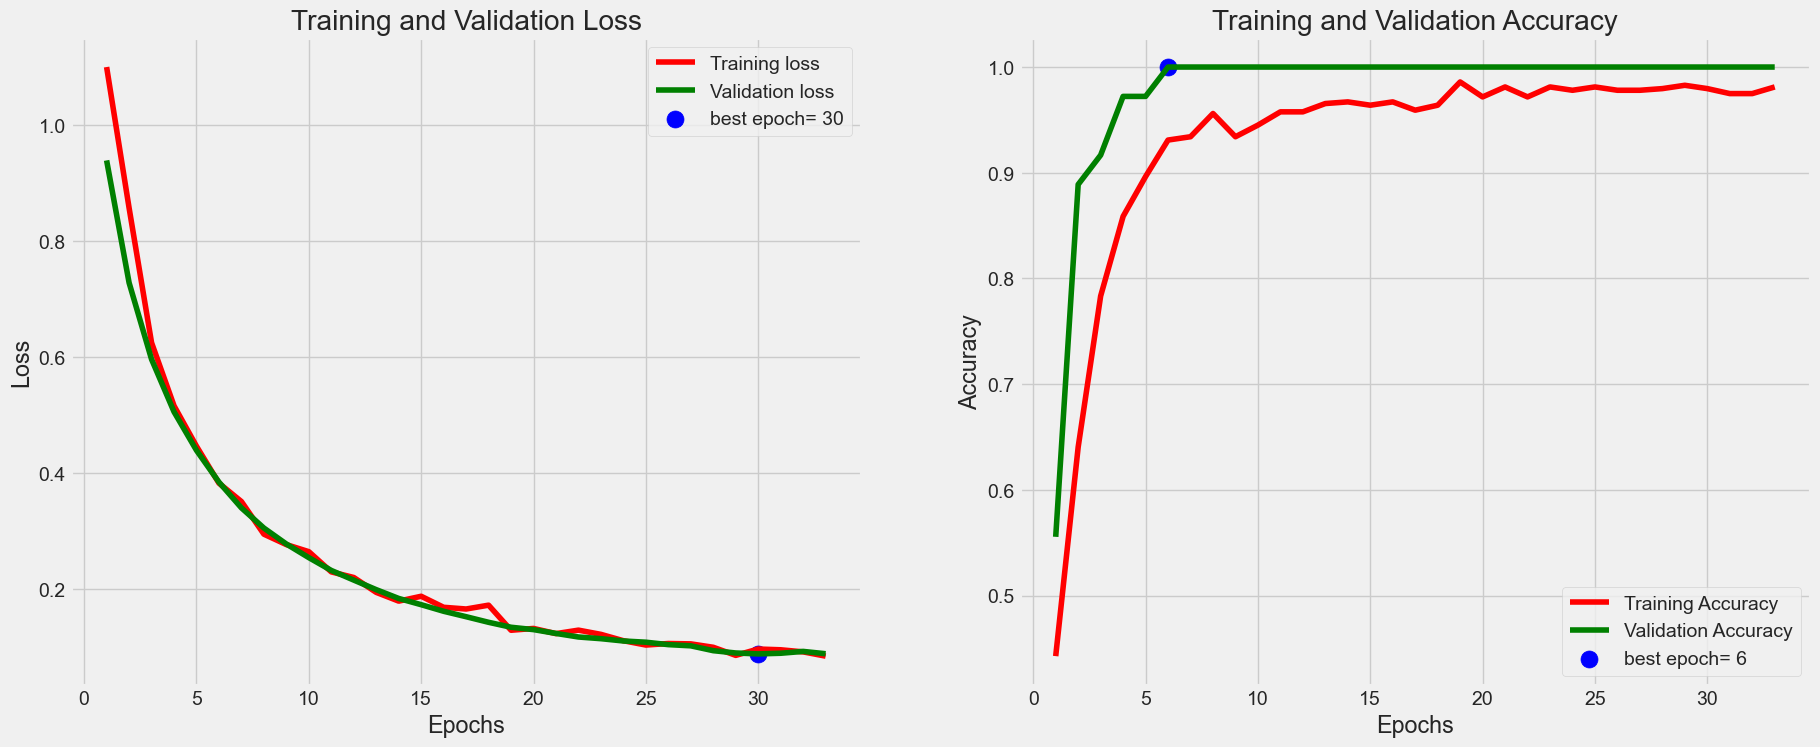

1/1 [==============================] - 2s 2s/step - loss: 0.1174 - accuracy: 0.9714
accuracy on the test set is 97.14 %



In [20]:
tr_plot(history,0)  #plot data pelatihan dan validasi mulai dari epoch 0
save_dir=r'./'
subject='NASNetMobile'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100  #evaluasi model pada set pengujian dan mengembalikan akurasi dalam bentuk persentase.
msg=f'accuracy on the test set is {acc:5.2f} %'   #Mencetak pesan akurasi dengan warna hijau di latar belakang gelap
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (subject +'.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

1/1 [==============================] - 8s 8s/step


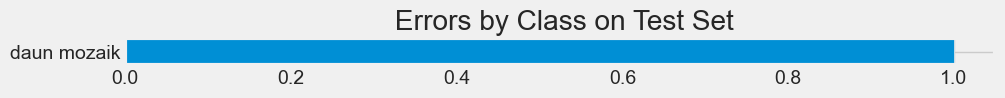

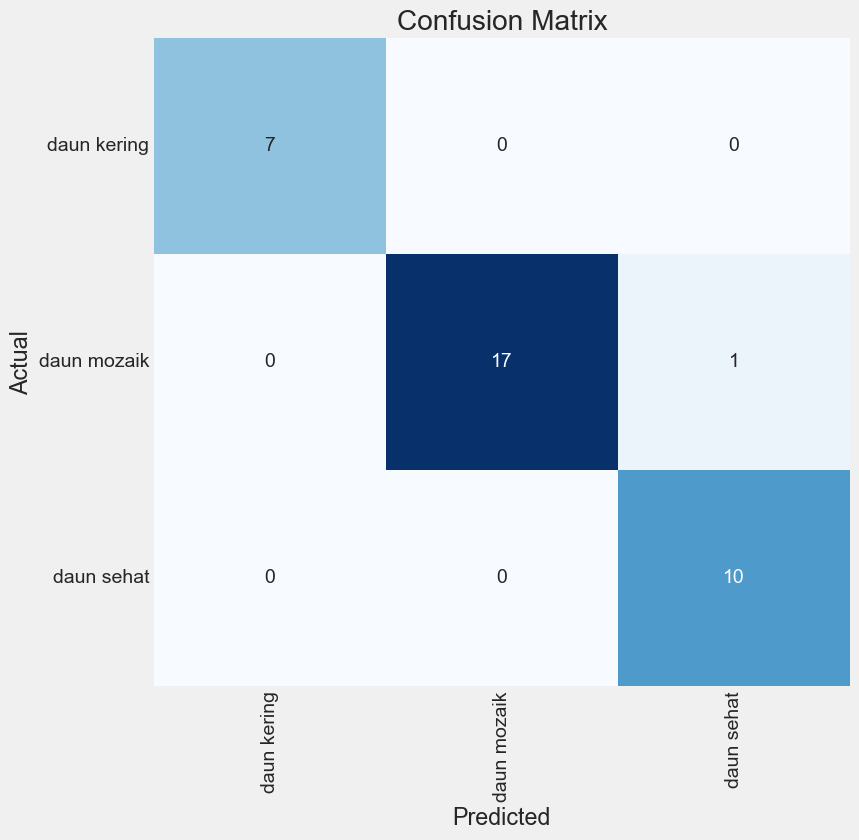

Classification Report:
----------------------
               precision    recall  f1-score   support

 daun kering       1.00      1.00      1.00         7
 daun mozaik       1.00      0.94      0.97        18
  daun sehat       0.91      1.00      0.95        10

    accuracy                           0.97        35
   macro avg       0.97      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35



In [16]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject ) 

1/1 [==============================] - 0s 85ms/step


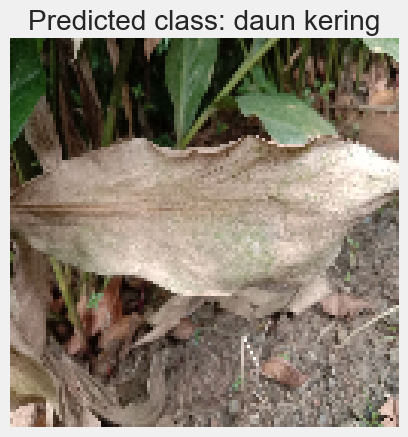

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


# Fungsi untuk memproses gambar
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img

# Prediksi gambar
def predict_image(img_path):
    img_array, original_img = preprocess_image(img_path)
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)[0]
    return class_idx, original_img

img_path = 'D:/SKRIPSI/TEST/4.jpg'
predicted_class, original_img = predict_image(img_path)

class_labels = ['daun kering', 'daun mozaik', 'daun sehat']

# Tampilkan gambar dan prediksi
plt.imshow(original_img)
plt.title(f'Predicted class: {class_labels[predicted_class]}')
plt.axis('off')
plt.show()
